# Hypothesis Testing and Transformations

Notebook by Jeremy Eng

## Introduction
- In this notebook, we will demo how to perform common statistical hypothesis tests in [scipy's stats library](https://docs.scipy.org/doc/scipy/reference/stats.html).
- We will also look at how to perform data transformations (manually) and their effect on the data's distribution.

## Scipy Installation
Make sure scipy is installed if it isn't already. Like most packages, it can be installed:
- using pip: `pip install scipy`
- or conda: `conda install -c anaconda scipy`

In [ ]:
# !conda install scipy
# !conda install seaborn
# !conda install -c anaconda scipy

In [ ]:
# !pip install scipy
# !pip install seaborn

## The dataset
We will use the 'tips' dataset for this demo. It can be easily loaded using seaborn's `load_dataset()` function. Feel free to take some time familiarizing yourself with the dataset.

In [ ]:
import pandas as pd
import seaborn as sns

tips_df = sns.load_dataset('tips')
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [ ]:
tips_df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [ ]:
tips_df['sex'].value_counts()
# tips_df['smoker'].value_counts()
# tips_df['day'].value_counts()
# tips_df['time'].value_counts()

Male      157
Female     87
Name: sex, dtype: int64

## Hypothesis Tests

### Normality test

Let's check out the distribution of our numerical variables total_bill, tip, and size. We can first do this graphically.

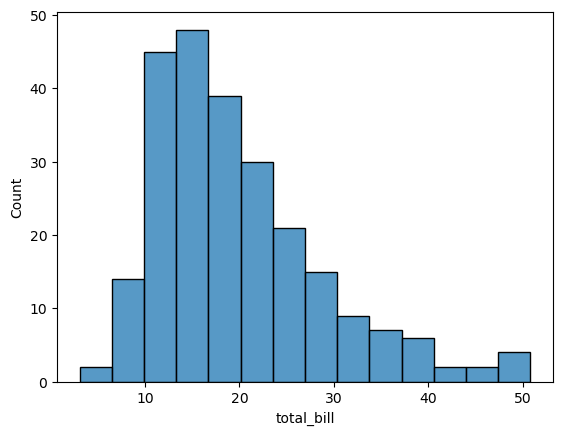

In [ ]:
import matplotlib.pyplot as plt

sns.histplot(tips_df['total_bill'])
# sns.histplot(tips_df['tip'])
# sns.histplot(tips_df['size'])

plt.show()

None of these variables seem to be normally distributed. Let's perform Shapiro-Wilk's normality test to confirm. For this test, remember:
- H<sub>0</sub>: data is normally distributed
- H<sub>a</sub>: data is not normally distributed

The python library `scipy` contains functions that will do statistical tests for you.

In [ ]:
from scipy import stats
stat, p = stats.shapiro(tips_df['total_bill'])
print('%0.30f' % p)

0.000000000332445293516059336980


In [ ]:
p

3.3244529351605934e-10

Most tests will return both a "test statistic" and a "p-value". To keep things simple, we can just focus on the p-value, but know you would come to the same conclusion if you used the test statistic. Since p<0.05, we reject the null hypothesis that the data is normally distributed.
> Scientific notation can be used for very small or big numbers. E.g.: 5.13e-4 = 5.13 x 10<sup>-4</sup> = 0.000513

> Later we will look at how performing a transformation on data can make it normally distributed.

All other common hypothesis tests can done in a similar manner. Simply pass the approriate data into the scipy function, and it will return a result. The documentation for all of scipy's stats functions can be found [here](https://docs.scipy.org/doc/scipy/reference/stats.html). Note that there are more than just the hypothesis testing functions.

### Correlation test (numerical data)

Going back to the dataset, we might hypothesize that the higher the total bill, the higher the tip should be, since most people tip on a percentage basis. We can check this hypothesis informally by viewing the data graphically via a scatter plot, and then more formally using a hypothesis test for linear correlation (Pearson's correlation coefficient test).

<AxesSubplot: xlabel='total_bill', ylabel='tip'>

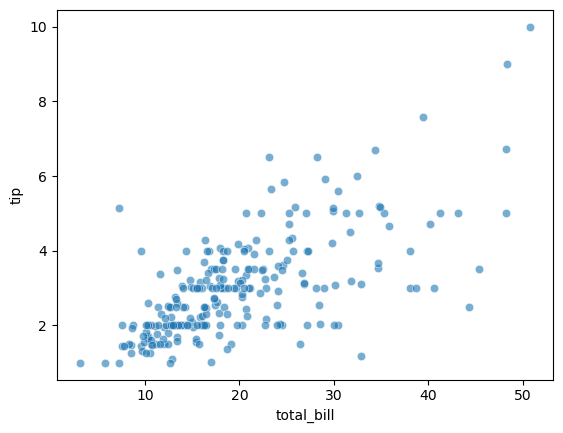

In [ ]:
sns.scatterplot(x=tips_df['total_bill'], y=tips_df['tip'], alpha=0.6)

In [ ]:
stat, p = stats.pearsonr(tips_df['total_bill'], tips_df['tip'])
print('%0.60f' % p)

0.000000000000000000000000000000000669247064686404756518256596


Whenever we perform a hypothesis test, we must remember what the null and alternative hypotheses are. For the Pearson's correlation coefficient test:
- H<sub>0</sub>: no correlation between the two variables
- H<sub>a</sub>: correlation between the two variables

Since the p-value is <0.05, we can conclude that there is significant correlation between total_bill and tip.

### Independence test (categorical data)

We can also test correlation between categorical variables by testing independence. Suppose we are interested in if there is any dependence between sex and smoker. We can use the **chi-squared test** for this, however the chi-squared function requires a "contingency table" with frequencies as input, instead of just the raw data. Luckily we can easily create this table using panda's `crosstab` function.

In [ ]:
contingency = pd.crosstab(tips_df['sex'], tips_df['time'])
contingency

time,Lunch,Dinner
sex,,
Male,33,124
Female,35,52


As you can see, a contingency table just reformats our raw data into a table of counts for each combination of categories. This is the input used for scipy's chi-squared function. We can see that the distribution of smokers/non-smokers across the different sexes seems pretty similar. This indicates sex and smoker are probably independent. Of course we can perform a hypothesis test to formalize our conclusion.

In [ ]:
stat, p, dof, expected = stats.chi2_contingency(contingency)
print(p)

0.002237400118075248


In [ ]:
p

0.002237400118075248

With a p-value>0.05, we cannot reject the null hypothesis that sex and smoker are independent.

### T-tests
A more interesting question we could ask from our data is: on average, do males and females tip different amounts? When comparing averages between two groups, we can use a T-test. There are actually a few variations of the t-test, based on other factors (equal variances, paired data). We will examine this in more detail shortly.

For now, let's start by just using the default t-test from scipy. Once again, we will need to reformat our data before we can feed it into the t-test function. We need two series of tip data--one for males and one for females. We can do this easily using pandas.

In [ ]:
tips_df['tip_as_percent'] = tips_df['tip'] / tips_df['total_bill']

In [ ]:
male_tips = tips_df[tips_df['sex']=='Male']['tip_as_percent']
female_tips = tips_df[tips_df['sex']=='Female']['tip_as_percent']
print(male_tips.mean(), female_tips.mean())

0.15765054700429743 0.16649073632892478


We can also view this comparison visually out of curiosity.

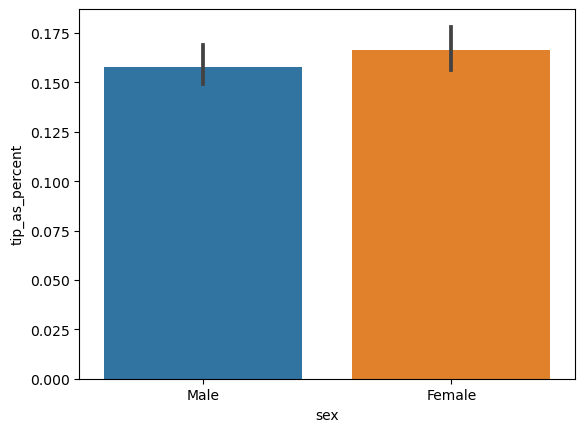

In [ ]:
sns.barplot(data=tips_df, x='sex', y='tip_as_percent')
plt.show()

The two averages seem close, but are they significantly different? This is a great demo on why we need hypothesis testing! To handle cases where we are unsure what to conclude.

In [ ]:
stat, p = stats.ttest_ind(male_tips, female_tips)
p

0.2797103849605489

Remember for a t-test, the hypotheses are:
- H<sub>0</sub>: averages are equal
- H<sub>a</sub>: averages are not equal

So since our p-value is >0.05, we do not reject the null hypothesis that the averages are equal. Therefore, we would conclude that there is not enough evidence to conclude that there is a significant difference between the average tip amount of males vs females.

#### T-test assumptions

The default t-test actually assumes that the variance of the data among the two groups is equal. I.e. the variance of male tips is equal to the variance of female tips. Was it valid to make this assumption? Well there's an <del>app</del> hypothesis test for that!

### Equal variance test

In statistics, **Levene's test** is a popular test for equal variances. There is also Bartlett's test (and others) that also test for equal variances, but some of these other tests require more assumptions. To keep things simple, let's just focus on the widely used Levene's test. Here we will just use it to compare the variances of two populations, but it can be extended to compare variances among more than two populations. Levene's test has the following hypotheses:
- H<sub>0</sub>: variances are equal
- H<sub>a</sub>: variances are not equal

In [ ]:
male_tips_var = male_tips.std()**2
female_tips_var = female_tips.std()**2

print([male_tips_var, female_tips_var])

[0.004196172792769981, 0.002876362058404039]


In [ ]:
stat, p = stats.levene(male_tips, female_tips)
p

0.49864785897998365

Since the p-value>0.05, we cannot conclude unequal variances, and so we were correct in using the original (default) t-test. For educational purposes, if we want to run the t-test without the equal variance assumption, we just need to pass in an extra parameter.

In [ ]:
# t-test for equal averages, without the equal variance assumption.
stat, p = stats.ttest_ind(male_tips, female_tips, equal_var=False)
p

0.2542456188927583

### T-test for paired data

If we have *paired data*, there is yet another t-test variation for this scenario.

**Paired data** is data the comes in pairs, so it is dependent. For our male/female tip data, the data was taken at different times and was independent of each other. We could shuffle the ordering of our data in the groups and it wouldn't make a difference.

On the other hand, paired data occurs when there is a natural matching in the data. For example, the total_bill and tip columns are paired data - they correspond to the same customer. So if I wanted to test if the average total_bill was equal to the average tip, we would used a T-test for paired data.
> Note: total_bill is obviously much larger than tip, but we will do this test anyway for educational purposes.

In [ ]:
# t-test for paired data
stat, p = stats.ttest_rel(tips_df['total_bill'], tips_df['tip'])
p

8.020018605020848e-91

What is your conclusion, based on the result of this test?

### Testing equal averages with more than two groups.

If we want to test averages across more than two groups, we can use the one-way ANOVA test. For this test:
- H<sub>0</sub>: all averages are equal
- H<sub>a</sub>: one or more averages are not equal

Perhaps we are interested in if people tip differently on each day of the week (Thu, Fri, Sat, Sun). Let's first take a look at this visually before we hypothesis test.

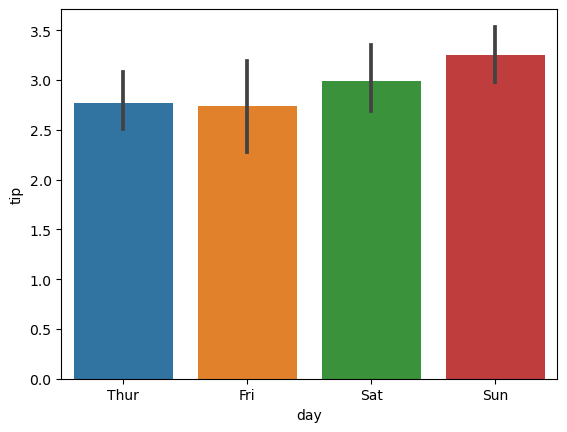

In [ ]:
sns.barplot(data=tips_df, x='day', y='tip')
plt.show()

It looks like the average tip on Sunday is larger than the rest, but is it significantly different? If we create series containing tips for each day of the week, we can use this as input for the one-way ANOVA test function.

In [ ]:
thu_tips = tips_df[tips_df['day']=='Thur']['tip']
fri_tips = tips_df[tips_df['day']=='Fri']['tip']
sat_tips = tips_df[tips_df['day']=='Sat']['tip']
sun_tips = tips_df[tips_df['day']=='Sun']['tip']

stat, p = stats.f_oneway(thu_tips, fri_tips, sat_tips, sun_tips)
p

0.1735885553040592

Since p-value > 0.05, there is not a significant difference in average tips among all of the days.

In [ ]:
tips_df

,total_bill,tip,sex,smoker,day,time,size,tip_as_percent
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204



## Scaling Data
Scaling data is an important concept that will be useful later on in the course. For now, let's just take a look on how to perform scaling. There are two common scaling methods: **standardizing** and **min-max normalization**.

### Standardizing
Standardizing centers the data at zero (mean=0) and measures the number of standard deviations away from the mean. This process can be represented mathematically:
$$
\dfrac{x_i - mean(x)}{std(x)}
$$
Let's standardize the total_bill column. We will also view its distribution before and after standardization.

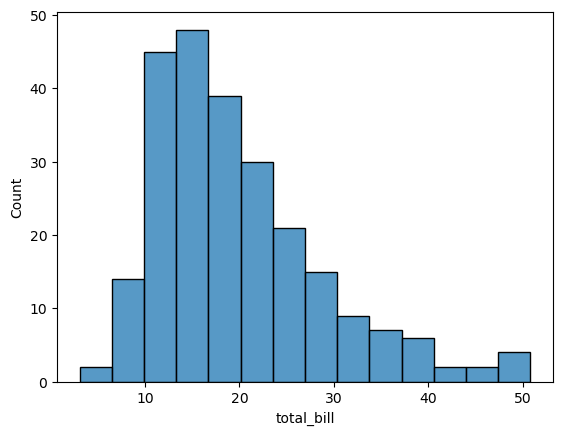

In [ ]:
total_bill = tips_df['total_bill'].values

# total_bill = np.append(total_bill, [0.01, 200])
sns.histplot(data=tips_df, x='total_bill')
plt.show()

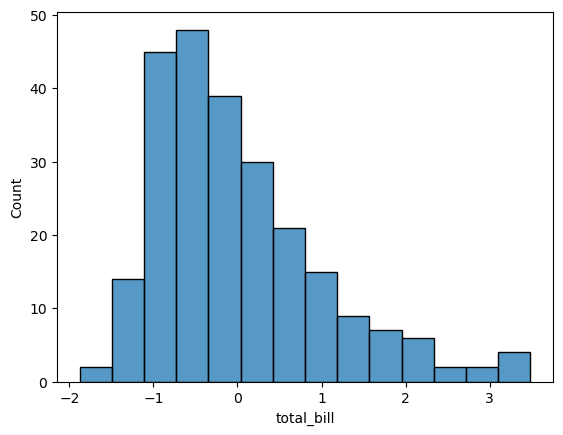

In [ ]:
total_bill_standardized = (tips_df['total_bill'] - tips_df['total_bill'].mean()) / tips_df['total_bill'].std()
sns.histplot(total_bill_standardized)
plt.show()

Notice how the data now seems to have a mean of zero, and a standard deviation of around 1. We can verify this.

In [ ]:
print(total_bill_standardized.mean(), total_bill_standardized.std())

-6.028875031263658e-17 1.0


> Note since standardization is a column task in data science, instead of having to do this manually everytime, later in the course you will see a Python "class" that can do this for you (from the sklearn library).

### Normalization

Another popular form of scaling is min-max normalization. This essentially squishes the data into a desired range (0 to 1 by default). This process can be represented mathematically:
$$
\dfrac{x_i - min(x)}{max(x) - min(x)}
$$
Let's once again do this on our total_bill data.

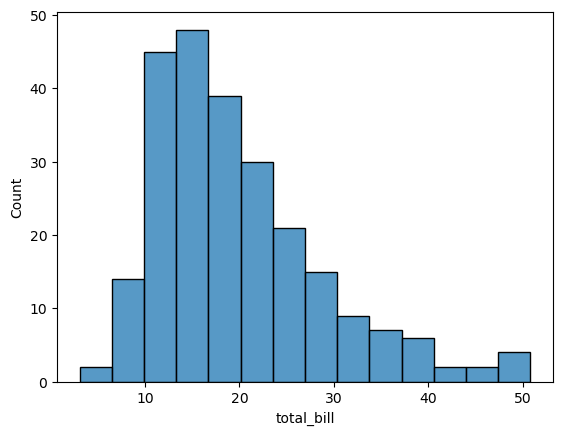

In [ ]:
sns.histplot(data=tips_df, x='total_bill')
plt.show()

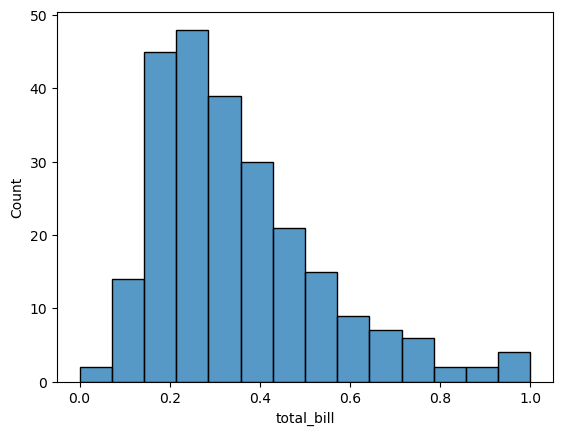

In [ ]:
total_bill_normalized = (tips_df['total_bill'] - tips_df['total_bill'].min()) / (tips_df['total_bill'].max() - tips_df['total_bill'].min())
sns.histplot(total_bill_normalized)
plt.show()

> There is also a Python "class" that can do this for you (from the sklearn library).

If we want to squish our data into an different interval than 0 to 1, we can now just multiply by the new desired range and add the start of the new desired interval.

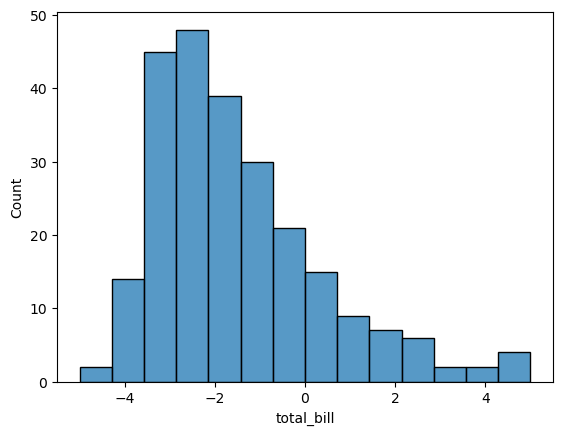

In [ ]:
start_new_interval = -5
end_new_interval = 5
new_range = end_new_interval - start_new_interval

total_bill_normalized_new_interval = total_bill_normalized*new_range + start_new_interval
sns.histplot(total_bill_normalized_new_interval)
plt.show()

## Transforming Data

Lastly, let's talk about transforming data! Sometimes we require our data to be normally distributed. If our data is not normally distributed, we can try to perform transformations to turn it into a normal distribution.

![](images/transformations.png)

Recall from earlier in this notebook that we saw total_bill was right-skewed and failed the Shapiro-Wilk test for normality.

3.3244529351605934e-10


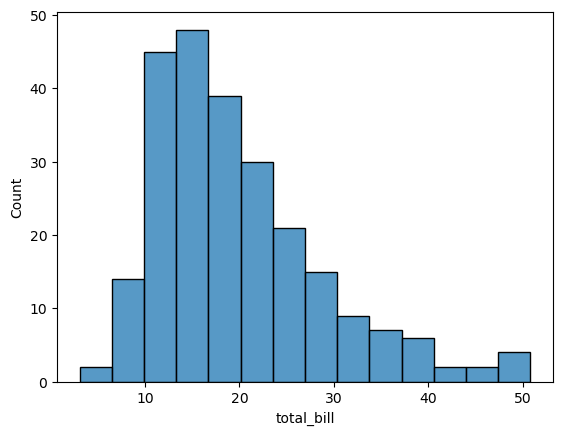

In [ ]:
stat, p = stats.shapiro(tips_df['total_bill'])
print(p)
sns.histplot(data=tips_df, x='total_bill')
plt.show()

### Right-skewed data
For right-skewed data, often a log transformation or some root transformation (square-root, cube-root, etc.) can be used.
> Be careful with negatives, since you can't take the log or the square root of a negative number! You can get around this by just doing some transformation to make it positive (like shifting by the minimum).

0.157652348279953


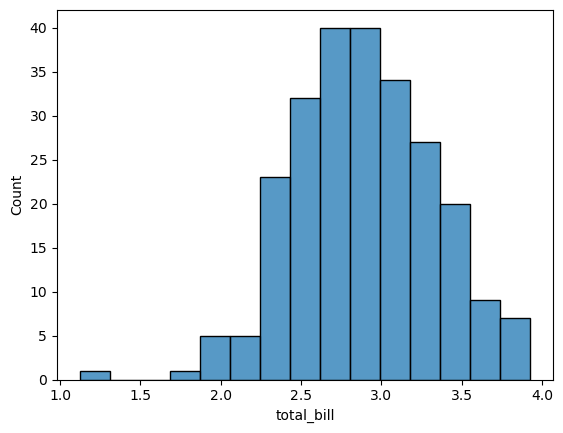

In [ ]:
import numpy as np
log_total_bill = np.log(tips_df['total_bill'])

stat, p = stats.shapiro(log_total_bill)
print(p)
sns.histplot(log_total_bill)
plt.show()

0.12955217063426971


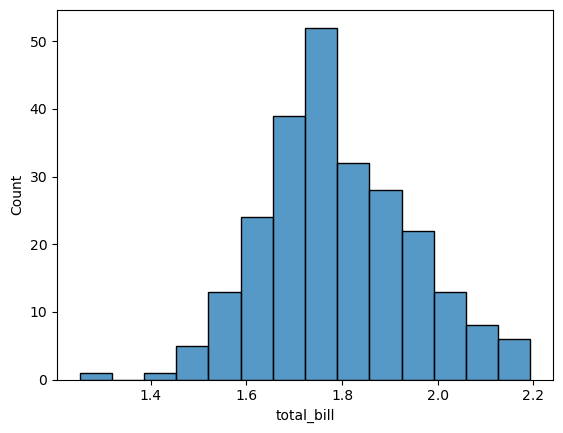

In [ ]:
sqrt_total_bill = tips_df['total_bill']**(1/5) # will need more than square root in this case

stat, p = stats.shapiro(sqrt_total_bill)
print(p)
sns.histplot(sqrt_total_bill)
plt.show()

### Left-skewed data
For left-skewed data, we often just convert it into right-skewed data (by subtracting it from the max) and then use the same techniques :)

Since we don't have left-skewed data in this dataset, let's do the following (for educational purposes):
1. turn our original right-skewed total_tip data into left-skewed data (and pretend this is our original).
2. turn this data into a normal distribution.

<AxesSubplot: xlabel='total_bill', ylabel='Count'>

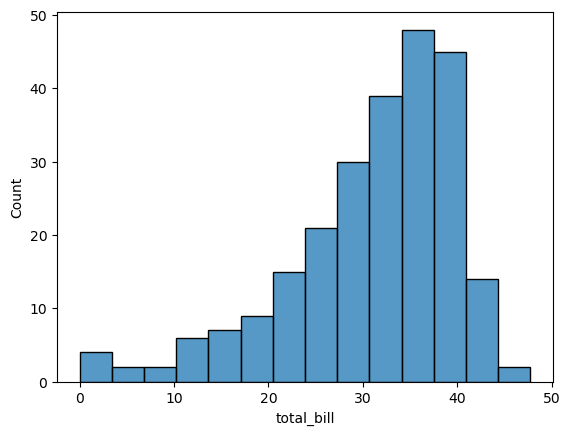

In [ ]:
# turn right-skewed original tip data and make it left-skewed
left_skew_total_tip = tips_df['total_bill'].max() - tips_df['total_bill']
sns.histplot(left_skew_total_tip)

So let's pretend this is our original and want to turn it into a normal distribution.

8.463678386760876e-05


<AxesSubplot: xlabel='total_bill', ylabel='Count'>

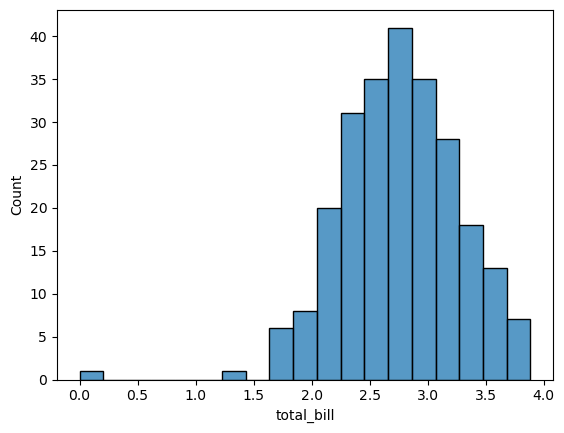

In [ ]:
log_left_skew = np.log(left_skew_total_tip.max() - left_skew_total_tip + 1) # +1 to avoid log of zero
stat, p = stats.shapiro(log_left_skew)
print(p)
sns.histplot(log_left_skew)

### Limits of normalization
If we normalize with minimum and maximum values, we may end up with our data squished too much because of outliers.

Let's add some outliers into the data to see what happens...

In [ ]:
total_bill = tips_df['total_bill'].values
total_bill = np.append(total_bill,[0.01, 200])

Let's see the histogram:

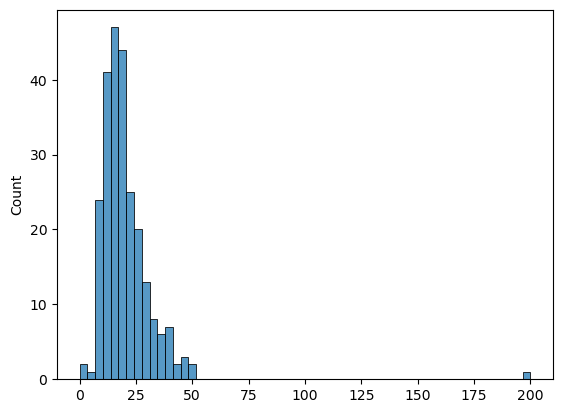

In [ ]:
sns.histplot(total_bill)
plt.show()

And what about if we normalize?

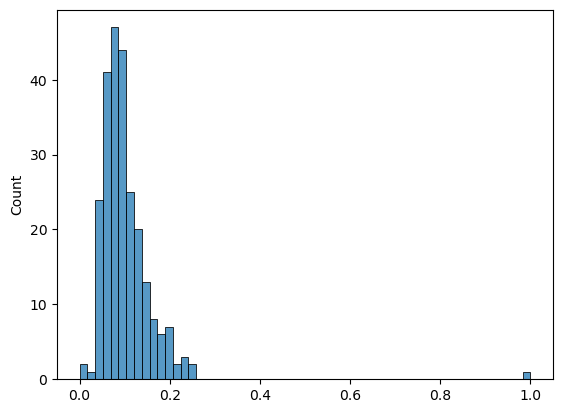

In [ ]:
total_bill_norm = (total_bill - np.min(total_bill))/(np.max(total_bill) - np.min(total_bill))
sns.histplot(total_bill_norm)
plt.show()

So now we see that the data we really care about is only in the 0-0.2 range, all because one really large data point is included.